In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import time 
from scipy import stats
import rebound
from scipy.special import gamma
from scipy.stats import norm, ks_2samp

# Merge dataframes

In [2]:
file_path = "/mnt/scratch-lustre/nhussain/data/distributions/Long300/"#"../../../LongScaleCsvs/"
planet_systems = np.loadtxt(file_path +"Order.txt", dtype = str)
print(planet_systems.shape)

(266,)


In [3]:
#save data
#info.to_csv("../../Figures/MCMCFigures/ProbabilityTable_Fixed_Covariences_{0}.csv".format(info.shape[0]))

#FILTER DATA (between 1e4 and 1e7)
info = pd.read_csv("../../Figures/MCMCFigures/ProbabilityTable_Fixed_Covariences_266.csv", index_col=0)

#fully integrated data
short_feats = pd.read_csv("../../csvs/deltatimes.csv", index_col =0 )
subsystem = info["ID"].values.astype(int)
sub_short = short_feats.loc[subsystem]
print(sub_short.shape)

#filtered data params
filtered = sub_short[ (sub_short["t"]>1e4) & (sub_short["t"]<1e7) &
                    (sub_short["t_shadow"]>1e4 ) & (sub_short["t_shadow"]<1e7) ] 

print(filtered.shape)
filtered_inds = filtered.index
#df.loc[df['column_name'].isin(some_values)]
valid = info.loc[info["ID"].isin(filtered_inds)] 
valid.head()

(266, 3)
(248, 3)


,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant
0,1007,0.130767,5.584131,0.461519,0.014201,0.010451,2.201230e-08
1,1021,0.185651,6.008010,0.330157,0.010570,0.007475,6.242409e-09
2,1025,0.154975,5.797448,0.387122,0.012399,0.008591,1.134396e-08
3,1041,0.123930,5.732675,0.489208,0.015449,0.010785,2.773702e-08
4,10518,0.143696,6.469809,0.431217,0.013868,0.009608,1.775222e-08


In [4]:
#info = pd.read_csv("../../Figures/MCMCFigures/Weibull_MCMC_Params_266.csv", index_col = 0)
info = pd.read_csv("../../Figures/MCMCFigures/Weibull_Parameters_266.csv", index_col =0 )
info['EV'] = info['Location'] + info['Alpha']*gamma(1+1/info['Gamma']) #EV of weibull
info.tail()

,ID,Gamma,Location,Alpha,EV
261,8462.0,2.096314,4.459373,1.199551e+00,5.521821
262,8582.0,0.184163,1.996260,1.191003e+00,304.531030
263,8744.0,0.833252,4.705257,1.546389e-01,4.875650
264,91.0,1.634222,4.750447,8.097842e-01,5.475133
265,99.0,0.999930,7.983125,8.810369e-16,7.983125


In [5]:
df = pd.merge(valid, info, on='ID', how='inner')
df.head()

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant,Gamma,Location,Alpha,EV
0,1007,0.130767,5.584131,0.461519,0.014201,0.010451,2.201230e-08,2.614027,4.447527,1.283371,5.587615
1,1021,0.185651,6.008010,0.330157,0.010570,0.007475,6.242409e-09,3.269655,4.989150,1.129664,6.002008
2,1025,0.154975,5.797448,0.387122,0.012399,0.008591,1.134396e-08,2.249906,4.965337,0.938566,5.796653
3,1041,0.123930,5.732675,0.489208,0.015449,0.010785,2.773702e-08,1.856930,4.863439,0.972277,5.726901
4,10518,0.143696,6.469809,0.431217,0.013868,0.009608,1.775222e-08,1.596694,5.781111,0.761953,6.464390


In [6]:
df.shape

(248, 11)

# Plot distributions. Red = gamma, black = gaussian

In [213]:
def plot_hists(planet_systems):
    ncol, nrow = 3,len(planet_systems)//3+1
    fig, axarr = plt.subplots(ncols=ncol,nrows=nrow)
    fig.set_size_inches((15, nrow*3))
    for jj , planet_sys in enumerate(planet_systems[:ncol*nrow]):
        data =pd.read_csv(file_path+'Sys_{0}_1e8.csv'.format(planet_sys), index_col = 0)
        
        data = data[data["t"]<1e8]
        data["logt"] = np.log10(data["t"])
        name = str(planet_sys)
        # make guassian
        gamma, mean, alpha =  df[df["ID"]==int(name)][["Gamma","Location", "Alpha"]].values[0]
        print(gamma, mean, alpha)
        x = np.linspace(data["logt"].min(), data["logt"].max(), 100)
        vals = stats.weibull_min.pdf(x,c=gamma,loc=mean,scale = alpha)
        #axarr[jj//ncol, jj%ncol ].plot(x, vals, linewidth = 4, color = "red")
        mean, sigma =  df[df["ID"]==int(name)][["Mean", "Sigma"]].values[0]

        x = np.linspace(mean - sigma*4, mean+sigma*4, 100)
        rv = norm(loc = mean, scale = sigma)
        axarr[jj//ncol, jj%ncol ].plot(x, rv.pdf(x), linewidth = 4, color = "black")
        
        data.hist("logt",  ax = axarr[jj//ncol, jj%ncol],  label = name, alpha = 0.7, normed = 1, color = "purple", edgecolor = "black", bins = 20)
        axarr[jj//ncol, jj%ncol ].set_title(name)
        edges = axarr[jj//ncol, jj%ncol ].axes.get_ylim() 
        
    plt.show()
    plt.close(fig)

In [8]:
df[df['EV']<4]

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant,Gamma,Location,Alpha,EV
8,1124,0.136483,4.170971,0.455038,0.014453,0.010170,2.159837e-08,1.130110,3.182193,0.816437,3.963255
32,1266,0.156639,3.776559,0.389771,0.012615,0.008841,1.243547e-08,1.825756,3.106470,0.758837,3.780851
171,2173,0.152814,3.785841,0.393255,0.012247,0.008799,1.160170e-08,2.158597,2.969858,0.921916,3.786311


1.13011039112 3.18219310829 0.816436566831
1.82575623718 3.10646984807 0.758837389057
2.15859663209 2.96985832097 0.921916233345


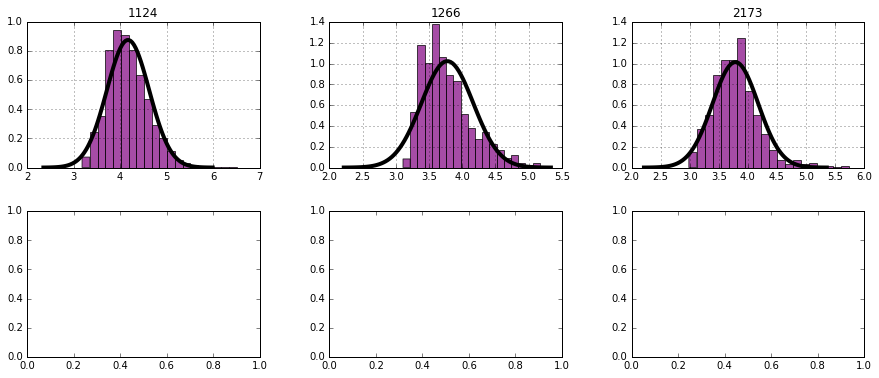

In [214]:
plot_hists(df[df['EV']<4]['ID'])

3.95483267777 5.10060632531 1.68689695896
3.95483267777 5.10060632531 1.68689695896
3.95483267777 5.10060632531 1.68689695896


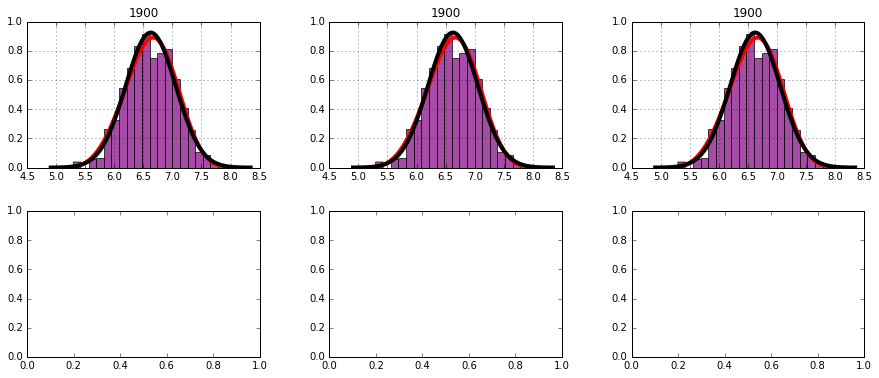

In [177]:
plot_hists([1900]*3)

# Plot Orbits

In [10]:
from rebound.plotting import OrbitPlotOneSlice
def plotorbits(IDs):
    ncol, nrow = 3,len(IDs)//3+1
    fig, axarr = plt.subplots(ncols=ncol,nrows=nrow)
    fig.set_size_inches((15, nrow*3))
    for jj , ID in enumerate(IDs[:ncol*nrow]):
        file = "/mnt/scratch-lustre/nhussain/data/distributions/Sys_{0}_1e8/initial_conditions/ic{1:0=7d}.bin".format(ID, 0)
        sim = rebound.Simulation.from_file(file)
        axarr[jj//ncol, jj%ncol].set_aspect('equal')
        OrbitPlotOneSlice(sim, axarr[jj//ncol, jj%ncol], trails=True) 
        

/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


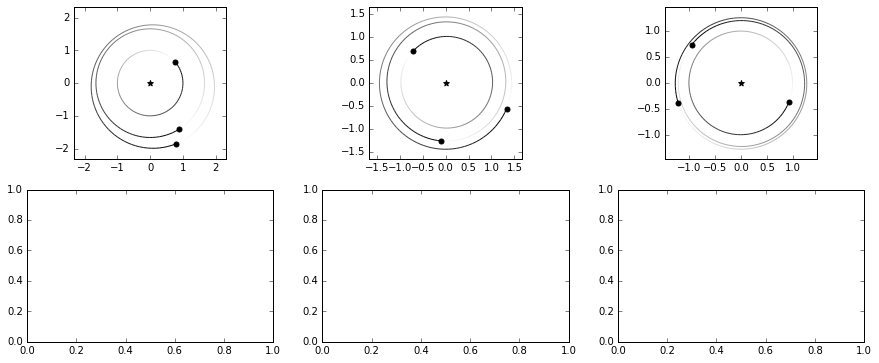

In [11]:
plotorbits(df[df['EV']<4]['ID'])

/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


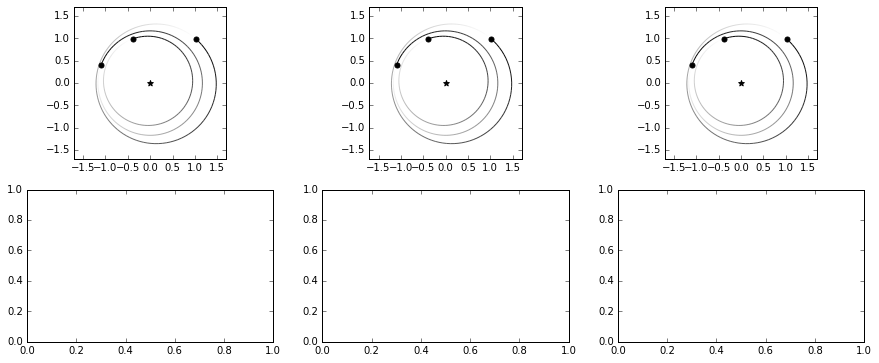

In [12]:
plotorbits([2364, 2364, 2364])

/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


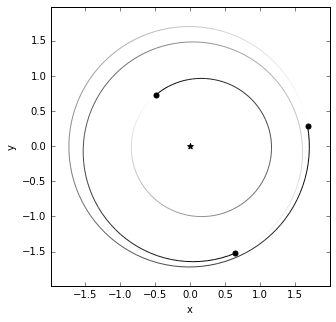

In [306]:
ID = 1880
file = "/mnt/scratch-lustre/nhussain/data/distributions/Sys_{0}_1e8/initial_conditions/ic{1:0=7d}.bin".format(ID, 0)
sim = rebound.Simulation.from_file(file)
fig = rebound.OrbitPlot(sim)   

In [307]:
sim.init_megno()
sim.integrate(1.e4)
megno = sim.calculate_megno()
print(megno, 1/sim.calculate_lyapunov())

2.4474409989673913 37471.556258873454


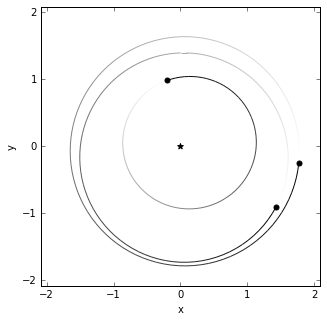

In [308]:
fig = rebound.OrbitPlot(sim)

In [329]:
from rebound.plotting import OrbitPlotOneSlice
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

def plotecc(ID, tmax=1.e4):
    fig, axarr = plt.subplots(ncols=3, figsize=(12,8))
    file = "/mnt/scratch-lustre/nhussain/data/distributions/Sys_{0}_1e8/initial_conditions/ic{1:0=7d}.bin".format(ID, 0)
    sim = rebound.Simulation.from_file(file)
    sim.init_megno()
    rebound.OrbitPlot(sim)
    ps = sim.particles
    RH12 = ((ps[1].m+ps[2].m)/3.)**(1./3.)*ps[1].a
    RH23 = ((ps[2].m+ps[3].m)/3.)**(1./3.)*ps[2].a
    Nout = 1000
    times = np.linspace(0, tmax, Nout)
    e1, e2, e3 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    a1, a2, a3 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    d12, d32 = np.zeros(Nout), np.zeros(Nout)
    a10 = sim.particles[1].a
    a20 = sim.particles[2].a
    a30 = sim.particles[3].a
    print('m', sim.particles[1].m, sim.particles[2].m, sim.particles[3].m)
    print('Pratio', sim.particles[2].P/sim.particles[1].P, sim.particles[3].P/sim.particles[2].P, sim.particles[3].P/sim.particles[1].P)
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
        except:
            print(sim.t)
            break
        e1[i] = sim.particles[1].e
        e2[i] = sim.particles[2].e
        e3[i] = sim.particles[3].e
        a1[i] = sim.particles[1].a
        a2[i] = sim.particles[2].a
        a3[i] = sim.particles[3].a
        de12 = np.sqrt((ps[2].e*np.cos(ps[2].pomega)-ps[1].e*np.cos(ps[1].pomega))**2 + (ps[2].e*np.sin(ps[2].pomega)-ps[1].e*np.sin(ps[1].pomega))**2)
        de32 = np.sqrt((ps[2].e*np.cos(ps[2].pomega)-ps[3].e*np.cos(ps[3].pomega))**2 + (ps[2].e*np.sin(ps[2].pomega)-ps[3].e*np.sin(ps[3].pomega))**2)
        da12 = (ps[2].a-ps[1].a)/ps[1].a
        da32 = (ps[3].a-ps[2].a)/ps[2].a
        d12[i] = (da12-de12)/RH12-1.
        d32[i] = (da32-de32)/RH23-1.
    
    axarr[0].plot(times[e1!=0], e1[e1!=0], label='e1')
    axarr[0].plot(times[e1!=0], e2[e1!=0], label='e2')
    axarr[0].plot(times[e1!=0], e3[e1!=0], label='e3')
    axarr[1].plot(times[e1!=0], (a1[e1!=0]-a10)/a10, label='da1')
    axarr[1].plot(times[e1!=0], (a2[e1!=0]-a20)/a20, label='da2')
    axarr[1].plot(times[e1!=0], (a3[e1!=0]-a30)/a30, label='da3')
    
    if d12[e1!=0].min() < d32[e1!=0].min():
        axarr[2].plot(times[e1!=0], d12[e1!=0], '.', label='d12')
    else:
        axarr[2].plot(times[e1!=0], d32[e1!=0], '.', label='d32')
    
    axarr[1].set_yscale('log')
    axarr[0].legend()
    axarr[1].legend()
    axarr[2].legend()
    
    p1 = np.poly1d(np.polyfit(times[e1!=0], e1[e1!=0], 3))
    p2 = np.poly1d(np.polyfit(times[e1!=0], e2[e1!=0], 3))
    p3 = np.poly1d(np.polyfit(times[e1!=0], e3[e1!=0], 3))

    m1 = p1(times[e1!=0])
    m2 = p2(times[e1!=0])
    m3 = p3(times[e1!=0])
    
    std1 = pd.Series(e1[e1!=0]-m1).std()
    std2 = pd.Series(e2[e1!=0]-m2).std()
    std3 = pd.Series(e3[e1!=0]-m3).std()
    std = max(max(std1, std2), std3)
    
    ax.plot(times[e1!=0], m1)
    ax.plot(times[e1!=0], m2)
    ax.plot(times[e1!=0], m3)
    
    print('std', std1, std2, std3)
    
    da1 = np.median((a1[e1!=0]-a10)/a10)
    da2 = np.median((a2[e1!=0]-a20)/a20)
    da3 = np.median((a3[e1!=0]-a30)/a30)
    
    da = max(max(da1, da2), da3)
    lyap = 1/sim.calculate_lyapunov()
    mind = min(d12.min(), d32.min())
    maxm = max(max(ps[1].m, ps[2].m), ps[3].m)
    return ax, std, da, lyap, mind, maxm, sim

/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


m 1.3517205214120819e-06 6.030669427572176e-05 3.3910970370555785e-05
Pratio 1.310262609823137 2.4737661505404294 3.241283292499238
std 0.0188853044378 0.000708017283355 0.00330698825256


ValueError: too many values to unpack (expected 4)

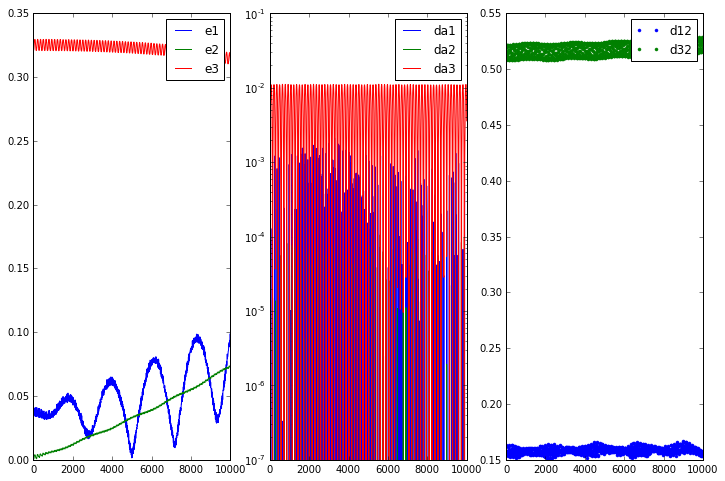

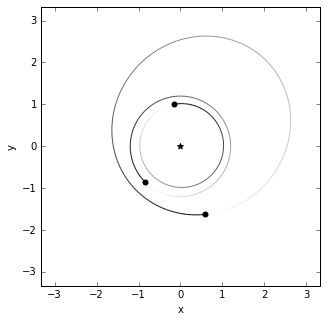

In [296]:
ax, std, da, tlyap, sim = plotecc(25)

In [223]:
da

0.00020018563624406004

In [15]:
pd.rolling_std(pd.Series(e1[e1!=0]), 10).median()

/mnt/raid-cita/dtamayo/p3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=10).std()
  if __name__ == '__main__':


0.0026184522118882225

# Make additional features to plot

In [330]:
def run(row):
    system = int(row['ID'])
    file = "/mnt/scratch-lustre/nhussain/data/distributions/Sys_{0}_1e8/initial_conditions/ic{1:0=7d}.bin".format(system, 0)
    
    sim = rebound.Simulation.from_file(file)
    ps = sim.particles
    RH12 = ((ps[1].m+ps[2].m)/3.)**(1./3.)*ps[1].a
    RH23 = ((ps[2].m+ps[3].m)/3.)**(1./3.)*ps[2].a
    sim.init_megno()
    Nout = 1000
    times = np.linspace(0, 1e4, Nout)
    e1, e2, e3 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    a1, a2, a3 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    d12, d32 = np.zeros(Nout), np.zeros(Nout)
    a10 = sim.particles[1].a
    a20 = sim.particles[2].a
    a30 = sim.particles[3].a
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
        except:
            break
        e1[i] = sim.particles[1].e
        e2[i] = sim.particles[2].e
        e3[i] = sim.particles[3].e
        a1[i] = sim.particles[1].a
        a2[i] = sim.particles[2].a
        a3[i] = sim.particles[3].a
        de12 = np.sqrt((ps[2].e*np.cos(ps[2].pomega)-ps[1].e*np.cos(ps[1].pomega))**2 + (ps[2].e*np.sin(ps[2].pomega)-ps[1].e*np.sin(ps[1].pomega))**2)
        de32 = np.sqrt((ps[2].e*np.cos(ps[2].pomega)-ps[3].e*np.cos(ps[3].pomega))**2 + (ps[2].e*np.sin(ps[2].pomega)-ps[3].e*np.sin(ps[3].pomega))**2)
        da12 = (ps[2].a-ps[1].a)/ps[1].a
        da32 = (ps[3].a-ps[2].a)/ps[2].a
        d12[i] = (da12-de12)/RH12-1.
        d32[i] = (da32-de32)/RH23-1.
    
    p1 = np.poly1d(np.polyfit(times[e1!=0], e1[e1!=0], 3))
    p2 = np.poly1d(np.polyfit(times[e1!=0], e2[e1!=0], 3))
    p3 = np.poly1d(np.polyfit(times[e1!=0], e3[e1!=0], 3))

    m1 = p1(times[e1!=0])
    m2 = p2(times[e1!=0])
    m3 = p3(times[e1!=0])
    
    std1 = pd.Series(e1[e1!=0]-m1).std()
    std2 = pd.Series(e2[e1!=0]-m2).std()
    std3 = pd.Series(e3[e1!=0]-m3).std()
    std = max(max(std1, std2), std3)
    
    da1 = np.median((a1[e1!=0]-a10)/a10)
    da2 = np.median((a2[e1!=0]-a20)/a20)
    da3 = np.median((a3[e1!=0]-a30)/a30)
    
    da = max(max(da1, da2), da3)
    
    np.random.seed(3)
    data =pd.read_csv("/mnt/scratch-lustre/nhussain/data/distributions/Long300/Sys_{0}_1e8.csv".format(system), index_col = 0)
    del data["Unnamed: 0.1"]
    del data["runstring"]
    data = data[data["t"]<1e8]
    data = np.log10(data["t"].values)

    # normal we want to match
    test = np.random.normal(loc=row["Mean"], scale=row["Sigma"], size = data.shape[0])

    #ks test
    try:
        statistic, KSpval = ks_2samp(data, test)
    except:
        statistic, KSpval = 0,0
    
    tlyap = 1/sim.calculate_lyapunov()
    mind = min(d12.min(), d32.min())
    maxm = max(max(ps[1].m, ps[2].m), ps[3].m)
    
    return std, da, tlyap, mind, maxm, KSpval

In [143]:
run(df[df['ID']==25])

/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


(0.018882837704949949, 0.52879576554564856)

In [21]:
def run(row):
    system = int(row['ID'])
    
    file = "/mnt/scratch-lustre/nhussain/data/distributions/Sys_{0}_1e8/initial_conditions/ic{1:0=7d}.bin".format(system, 0)
    sim = rebound.Simulation.from_file(file)
    Nout = 1000
    times = np.linspace(0, 1e6, Nout)
    e1, e2, e3 = np.zeros(Nout), np.zeros(Nout), np.zeros(Nout)
    for i, time in enumerate(times):
        try:
            sim.integrate(time)
        except:
            break
        e1[i] = sim.particles[1].e
        e2[i] = sim.particles[2].e
        e3[i] = sim.particles[3].e
    
    std1 = pd.rolling_std(pd.Series(e1[e1!=0]), 10).median()
    std2 = pd.rolling_std(pd.Series(e2[e1!=0]), 10).median()
    std3 = pd.rolling_std(pd.Series(e3[e1!=0]), 10).median()
    std = max(max(std1, std2), std3)
    
    #do tests for only valid systems within the instability time range cuts

    np.random.seed(3)
    data =pd.read_csv("/mnt/scratch-lustre/nhussain/data/distributions/Long300/Sys_{0}_1e8.csv".format(system), index_col = 0)
    del data["Unnamed: 0.1"]
    del data["runstring"]
    data = data[data["t"]<1e8]
    data = np.log10(data["t"].values)

    # normal we want to match
    test = np.random.normal(loc=row["Mean"], scale=row["Sigma"], size = data.shape[0])

    #ks test
    try:
        statistic, KSpval = ks_2samp(data, test)
    except:
        statistic, KSpval = 0,0
    
    return std, KSpval

In [19]:
def run(row):
    system = int(row['ID'])
    data =pd.read_csv(file_path+'Sys_{0}_1e8.csv'.format(system), index_col = 0)
    mad = np.log10(data['t']).mad()
    mint = np.log10(data['t'].min())
    med = np.log10(data['t'].median())
    f = "/mnt/scratch-lustre/nhussain/data/distributions/Sys_{0}_1e8/initial_conditions/ic{1:0=7d}.bin".format(system, 0)
    
    sim = rebound.Simulation.from_file(f)
    ps = sim.particles
    RH12 = ((ps[1].m+ps[2].m)/3.)**(1./3.)*ps[1].a
    RH23 = ((ps[2].m+ps[3].m)/3.)**(1./3.)*ps[2].a

    minP = min(ps[2].P/ps[1].P, ps[3].P/ps[2].P)
    maxe = max(max(ps[1].e, ps[2].e), ps[3].e)
    minRH = min(RH12, RH23)
    cross1 = (ps[2].a*(1.-ps[2].e)-ps[1].a*(1+ps[1].e))/RH12
    cross2 = (ps[3].a*(1.-ps[3].e)-ps[2].a*(1+ps[2].e))/RH23
    mincross = min(cross1, cross2)
    
    #do tests for only valid systems within the instability time range cuts

    np.random.seed(3)
    data =pd.read_csv("/mnt/scratch-lustre/nhussain/data/distributions/Long300/Sys_{0}_1e8.csv".format(system), index_col = 0)
    del data["Unnamed: 0.1"]
    del data["runstring"]
    data = data[data["t"]<1e8]
    data = np.log10(data["t"].values)

    # normal we want to match
    test = np.random.normal(loc=row["Mean"], scale=row["Sigma"], size = data.shape[0])

    #ks test
    try:
        statistic, KSpval = ks_2samp(data, test)
    except:
        statistic, KSpval = 0,0
    
    return minP, maxe, minRH, mincross, mint, mad, med, KSpval

In [331]:
%%time
df['maxstddetrended'], df['maxda'], df['tlyap'], df['mind'], df['KSpval'] = zip(*df.apply(run, axis=1))
df.head()

/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


ValueError: too many values to unpack (expected 5)

In [9]:
df['minP'], df['maxe'], df['minRH'], df['mincross'], df['mint'], df['mad'], df['med'], df['KSpval'] = zip(*df.apply(run, axis=1))
df.head()

/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant,Gamma,Location,Alpha,EV,minP,maxe,minRH,mincross,mint,mad,med,KSpval
0,1007,0.130767,5.584131,0.461519,0.014201,0.010451,2.201230e-08,2.614027,4.447527,1.283371,5.587615,1.821521,0.277217,0.027468,3.520517,4.476226,0.366226,5.548418,9.386954e-02
1,1021,0.185651,6.008010,0.330157,0.010570,0.007475,6.242409e-09,3.269655,4.989150,1.129664,6.002008,1.131163,0.004271,0.007287,7.795756,5.030155,0.258951,5.995834,3.072049e-01
2,1025,0.154975,5.797448,0.387122,0.012399,0.008591,1.134396e-08,2.249906,4.965337,0.938566,5.796653,1.066340,0.049713,0.005722,7.274974,4.986394,0.302861,5.768233,2.789818e-02
3,1041,0.123930,5.732675,0.489208,0.015449,0.010785,2.773702e-08,1.856930,4.863439,0.972277,5.726901,1.098957,0.041868,0.011382,2.107808,4.866753,0.381478,5.646139,8.813668e-07
4,10518,0.143696,6.469809,0.431217,0.013868,0.009608,1.775222e-08,1.596694,5.781111,0.761953,6.464390,1.376369,0.132402,0.013379,13.122136,5.798014,0.355084,6.410318,4.772941e-03


In [314]:
df.head()

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant,Gamma,Location,Alpha,EV,maxstddetrended,KSpval,maxda,tlyap,mind
0,1007,0.130767,5.584131,0.461519,0.014201,0.010451,2.201230e-08,2.614027,4.447527,1.283371,5.587615,0.002645,9.386954e-02,0.032087,109.531825,4.544416
1,1021,0.185651,6.008010,0.330157,0.010570,0.007475,6.242409e-09,3.269655,4.989150,1.129664,6.002008,0.002670,3.072049e-01,0.000168,1509.935504,6.145565
2,1025,0.154975,5.797448,0.387122,0.012399,0.008591,1.134396e-08,2.249906,4.965337,0.938566,5.796653,0.001989,2.789818e-02,0.000109,1174.252058,5.409844
3,1041,0.123930,5.732675,0.489208,0.015449,0.010785,2.773702e-08,1.856930,4.863439,0.972277,5.726901,0.001031,8.813668e-07,0.000636,-288490.460205,0.765964
4,10518,0.143696,6.469809,0.431217,0.013868,0.009608,1.775222e-08,1.596694,5.781111,0.761953,6.464390,0.000726,4.772941e-03,0.000015,65271.061537,10.796477


In [315]:
df.to_csv('distributionfeaturesnew.csv')

In [316]:
df = pd.read_csv('distributionfeaturesnew.csv', index_col=0)
df.head()

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant,Gamma,Location,Alpha,EV,maxstddetrended,KSpval,maxda,tlyap,mind
0,1007,0.130767,5.584131,0.461519,0.014201,0.010451,2.201230e-08,2.614027,4.447527,1.283371,5.587615,0.002645,9.386954e-02,0.032087,109.531825,4.544416
1,1021,0.185651,6.008010,0.330157,0.010570,0.007475,6.242409e-09,3.269655,4.989150,1.129664,6.002008,0.002670,3.072049e-01,0.000168,1509.935504,6.145565
2,1025,0.154975,5.797448,0.387122,0.012399,0.008591,1.134396e-08,2.249906,4.965337,0.938566,5.796653,0.001989,2.789818e-02,0.000109,1174.252058,5.409844
3,1041,0.123930,5.732675,0.489208,0.015449,0.010785,2.773702e-08,1.856930,4.863439,0.972277,5.726901,0.001031,8.813668e-07,0.000636,-288490.460205,0.765964
4,10518,0.143696,6.469809,0.431217,0.013868,0.009608,1.775222e-08,1.596694,5.781111,0.761953,6.464390,0.000726,4.772941e-03,0.000015,65271.061537,10.796477


In [317]:
df[df['ID']==2364]

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant,Gamma,Location,Alpha,EV,maxstddetrended,KSpval,maxda,tlyap,mind
213,2364,0.654272,4.930846,0.090603,0.002979,0.002057,3.745564e-11,1.777544,4.779433,0.169554,4.930311,0.000254,2.142884e-45,0.000364,36303.135052,5.906212


In [318]:
bad = df[df['KSpval']<1.e-10]['ID'].values
bad

array([ 1190,  1223,  1230,  1277,  1356,  1364,  1424,  1508,  1601,
        1640,  1742,  1775,  1785,  1819,  1829,  1837,  1880,  1886,
        1928,  1942,  1946,  1957,  1992,  2077,  2215,  2274,  2288,
        2300,  2341,  2364,  2399, 24453, 24930,  4753,  8744])

In [319]:
good = df[df['KSpval']>1.e-10]['ID'].values
good

array([ 1007,  1021,  1025,  1041, 10518,  1052,  1107,  1120,  1124,
        1128,  1136,  1137,  1138,  1169,  1174,  1194,  1197,     1,
        1204,  1206, 12073,  1208,  1217,  1235,  1237,  1241,  1248,
        1251,  1261,  1266,  1270, 12840,  1308,  1313,  1323,  1324,
        1337,  1344,  1350,  1366,  1375,  1379,  1396,  1403,  1408,
        1412,  1426,  1438,  1449,  1476,  1488, 15003,  1504,  1507,
        1513,  1514, 15220,  1590,  1598,  1613,  1616,  1617,  1625,
        1627,  1635,  1636,  1646,  1648,  1657, 16588,  1667,  1675,
        1689,  1691,  1720,  1753, 17641,  1766,  1768,  1791,  1796,
        1799,  1805,  1806,  1810,  1815,  1823,  1827,  1831,  1838,
        1843,  1850,  1852, 18539, 18651,  1875,  1877,  1879,  1899,
        1900,  1911,  1913,  1918, 19197,  1922,  1924,  1929,  1943,
        1954, 19591,  1971,  1979, 19898,  1996,  1999, 20041,  2010,
        2018,  2030,  2032,  2048,  2059, 20620,  2062,  2063,  2066,
        2081,  2083,

In [320]:
weirdmask = df['KSpval'] < 1.e-10 #df['ID'].isin(weird_systems)
weird = df[weirdmask]

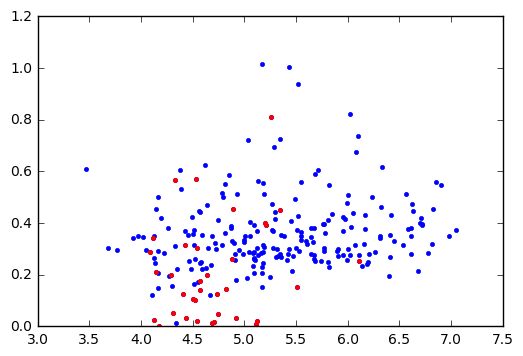

In [17]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(df['med'], df['mad'], 'b.')
ax.plot(weird['med'], weird['mad'], 'r.')

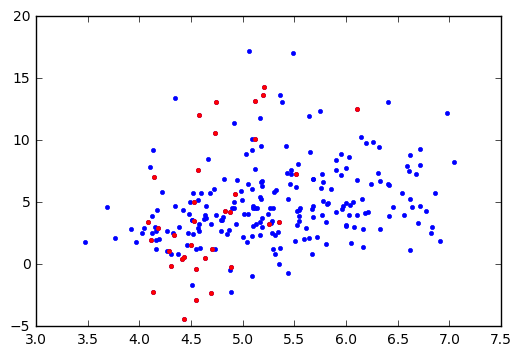

In [18]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(df['med'], df['mincross'], 'b.')
ax.plot(weird['med'], weird['mincross'], 'r.')

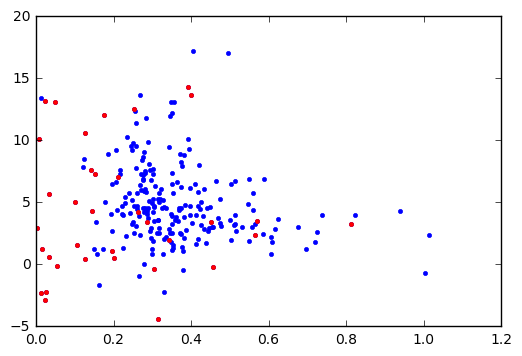

In [19]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(df['mad'], df['mincross'], 'b.')
ax.plot(weird['mad'], weird['mincross'], 'r.')

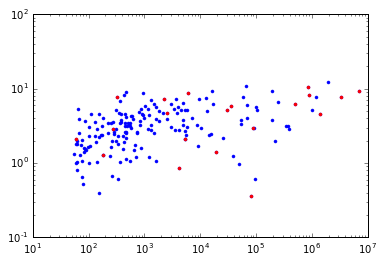

In [321]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(df['tlyap'], df['mind'], 'b.')
ax.plot(weird['tlyap'], weird['mind'], 'r.')
ax.set_yscale('log')
ax.set_xscale('log')

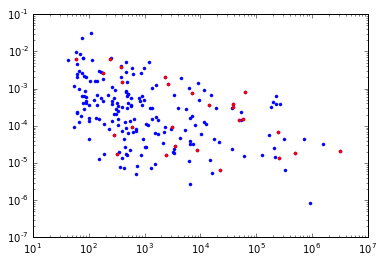

In [267]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(df['tlyap'], df['maxda'], 'b.')
ax.plot(weird['tlyap'], weird['maxda'], 'r.')
ax.set_yscale('log')
ax.set_xscale('log')

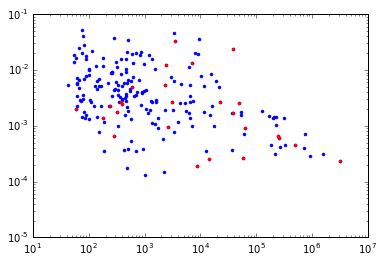

In [268]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(df['tlyap'], df['maxstddetrended'], 'b.')
ax.plot(weird['tlyap'], weird['maxstddetrended'], 'r.')
ax.set_yscale('log')
ax.set_xscale('log')

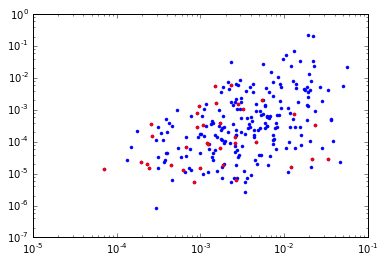

In [245]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(df['maxstddetrended'], df['maxda'], 'b.')
ax.plot(weird['maxstddetrended'], weird['maxda'], 'r.')
ax.set_yscale('log')
ax.set_xscale('log')

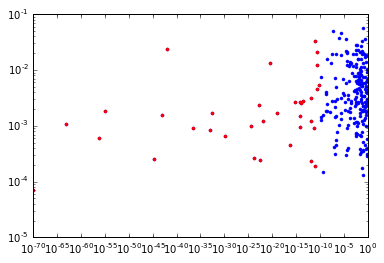

In [150]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(df['KSpval'], df['maxstddetrended'], 'b.')
ax.plot(weird['KSpval'], weird['maxstddetrended'], 'r.')
ax.set_yscale('log')
ax.set_xscale('log')

In [324]:
bigmind = df[(df['mind']>0.01) & (df['KSpval']<1.e-10)][['ID', 'mind', 'KSpval']].sort('KSpval')
bigmind

/mnt/raid-cita/dtamayo/p3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,ID,mind,KSpval
102,1829,11.901273,1.084816e-70
67,1601,7.877339,7.695895e-64
44,1364,0.221885,5.030259e-57
182,2215,7.741012,9.033013e-56
213,2364,5.906212,2.142884e-45
99,1819,1.270048,1.003610e-43
43,1356,5.231656,2.331498e-37
75,1640,4.593236,1.228910e-33
199,2288,7.191029,2.141012e-33
135,1992,6.182491,1.429879e-30


In [178]:
df[df['maxstddetrended']>0.01][['ID', 'maxstddetrended', 'KSpval']].sort('KSpval')

/mnt/raid-cita/dtamayo/p3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,ID,maxstddetrended,KSpval
114,1880,0.023420,1.252303e-42
25,1230,0.013164,3.016345e-21
124,1928,0.033107,8.270878e-12
126,1942,0.012249,2.122221e-11
85,1742,0.021483,2.706690e-11
161,2117,0.015734,2.791248e-09
198,2285,0.013189,1.983036e-08
53,1426,0.019531,3.288992e-08
54,1438,0.049844,4.457569e-08
205,2301,0.019214,2.132645e-07


In [173]:
df[df['KSpval']<1.e-10][['ID', 'maxstddetrended', 'KSpval']].sort('KSpval')

/mnt/raid-cita/dtamayo/p3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,ID,maxstddetrended,KSpval
102,1829,0.000071,1.084816e-70
67,1601,0.001081,7.695895e-64
44,1364,0.000616,5.030259e-57
182,2215,0.001843,9.033013e-56
213,2364,0.000254,2.142884e-45
99,1819,0.001535,1.003610e-43
114,1880,0.023420,1.252303e-42
43,1356,0.000912,2.331498e-37
75,1640,0.000844,1.228910e-33
199,2288,0.001725,2.141012e-33


In [175]:
df[(df['KSpval']>1.e-10) & (df['maxstddetrended']<1.e-3)][['ID', 'maxstddetrended', 'KSpval']].sort('KSpval')

/mnt/raid-cita/dtamayo/p3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,ID,maxstddetrended,KSpval
56,1476,0.000149,3.558185e-10
169,2161,0.000420,7.572132e-08
216,2377,0.000311,1.213526e-07
218,23975,0.000454,2.132645e-07
132,1971,0.000547,2.418179e-07
208,2336,0.000779,3.535890e-07
36,1308,0.000295,2.326071e-05
212,2359,0.000925,5.395163e-05
60,1507,0.000363,5.395163e-05
186,2223,0.000399,8.117557e-05


In [184]:
a = df[(df['KSpval']<1.e-10) & (df['maxstddetrended']>1.e-2)][['ID', 'maxstddetrended', 'KSpval']].sort('KSpval')
a

/mnt/raid-cita/dtamayo/p3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,ID,maxstddetrended,KSpval
114,1880,0.023420,1.252303e-42
25,1230,0.013164,3.016345e-21
124,1928,0.033107,8.270878e-12
126,1942,0.012249,2.122221e-11
85,1742,0.021483,2.706690e-11


/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:369: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


m 1.7870945777867728e-05 2.9759984599562e-07 4.459987342687934e-06
Pratio 1.72901198635237 1.187471259182496 2.0531520405754775
67574.04537970363
std 0.000111702028448 0.0150526754839 0.00190254872453


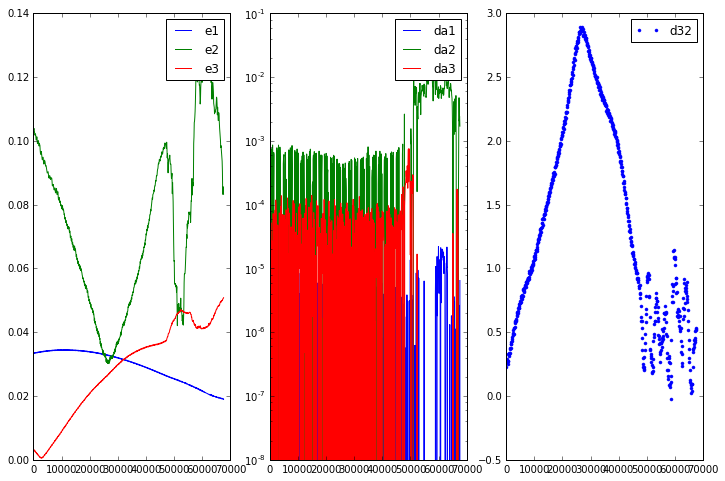

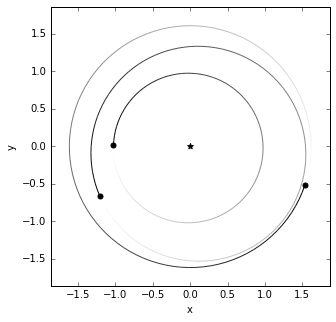

In [327]:
ax, std, da, tlyap, mind, sim = plotecc(1364, 1.e5)

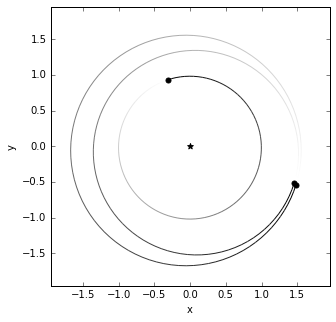

In [328]:
fig = rebound.OrbitPlot(sim)

0.70894066717 4.4612775313 0.191758583486
1.41310045906 4.47393167553 1.0864834806
0.90637631321 4.29043053605 0.399178691595
1.5059817667 4.32146184653 0.884831811701
1.66863127935 3.55295700379 1.3173606241


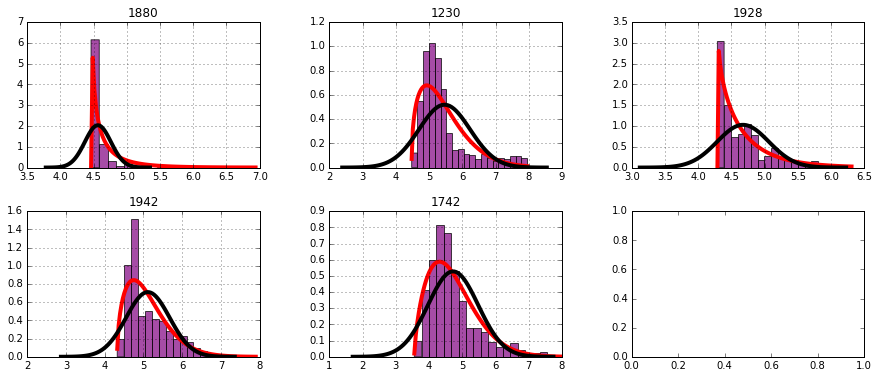

In [185]:
plot_hists(a['ID'])

In [209]:
bad = df[(df['KSpval']<1.e-10)][['ID', 'maxstddetrended', 'KSpval']].sort('KSpval')

/mnt/raid-cita/dtamayo/p3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [211]:
bad.head()

,ID,maxstddetrended,KSpval
102,1829,0.000071,1.084816e-70
67,1601,0.001081,7.695895e-64
44,1364,0.000616,5.030259e-57
182,2215,0.001843,9.033013e-56
213,2364,0.000254,2.142884e-45


In [212]:
bad.shape

(35, 3)

0.913574821091 5.11056062599 0.0450298550618
0.890051299254 4.41661187566 0.0336347750484
0.278281876623 4.68683319613 0.0864509926747
0.99316500023 4.31851557632 0.150467334391
1.77754435998 4.77943269645 0.169554341807
1.43272304911 4.15581144108 0.181928493952
0.70894066717 4.4612775313 0.191758583486
1.29881223833 4.50691427887 0.0537789135472
1.14350054773 4.69323253344 0.0819892754916
0.983246075541 4.49261573243 0.260480693859
1.79135610204 4.28916229884 0.489791181939
1.0540933271 5.10998105842 0.0124734852746
0.748105405245 4.1739215789 0.00262561485307
1.38467090659 3.8109591194 0.990518056577
0.79464514112 4.66478974305 0.461983076594
3.72328143265 4.09555323175 0.530298474652
1.41310045906 4.47393167553 1.0864834806
1.11667536563 4.67411357132 0.392666618489
0.946483246051 5.35177412093 0.201319348716
0.833251932557 4.70525713081 0.154638909864
1.56379313427 4.31521485665 0.375305869029
1.97471642854 3.80950366586 0.872817294799
1.54642245646 3.97182173429 0.426468894845
2.

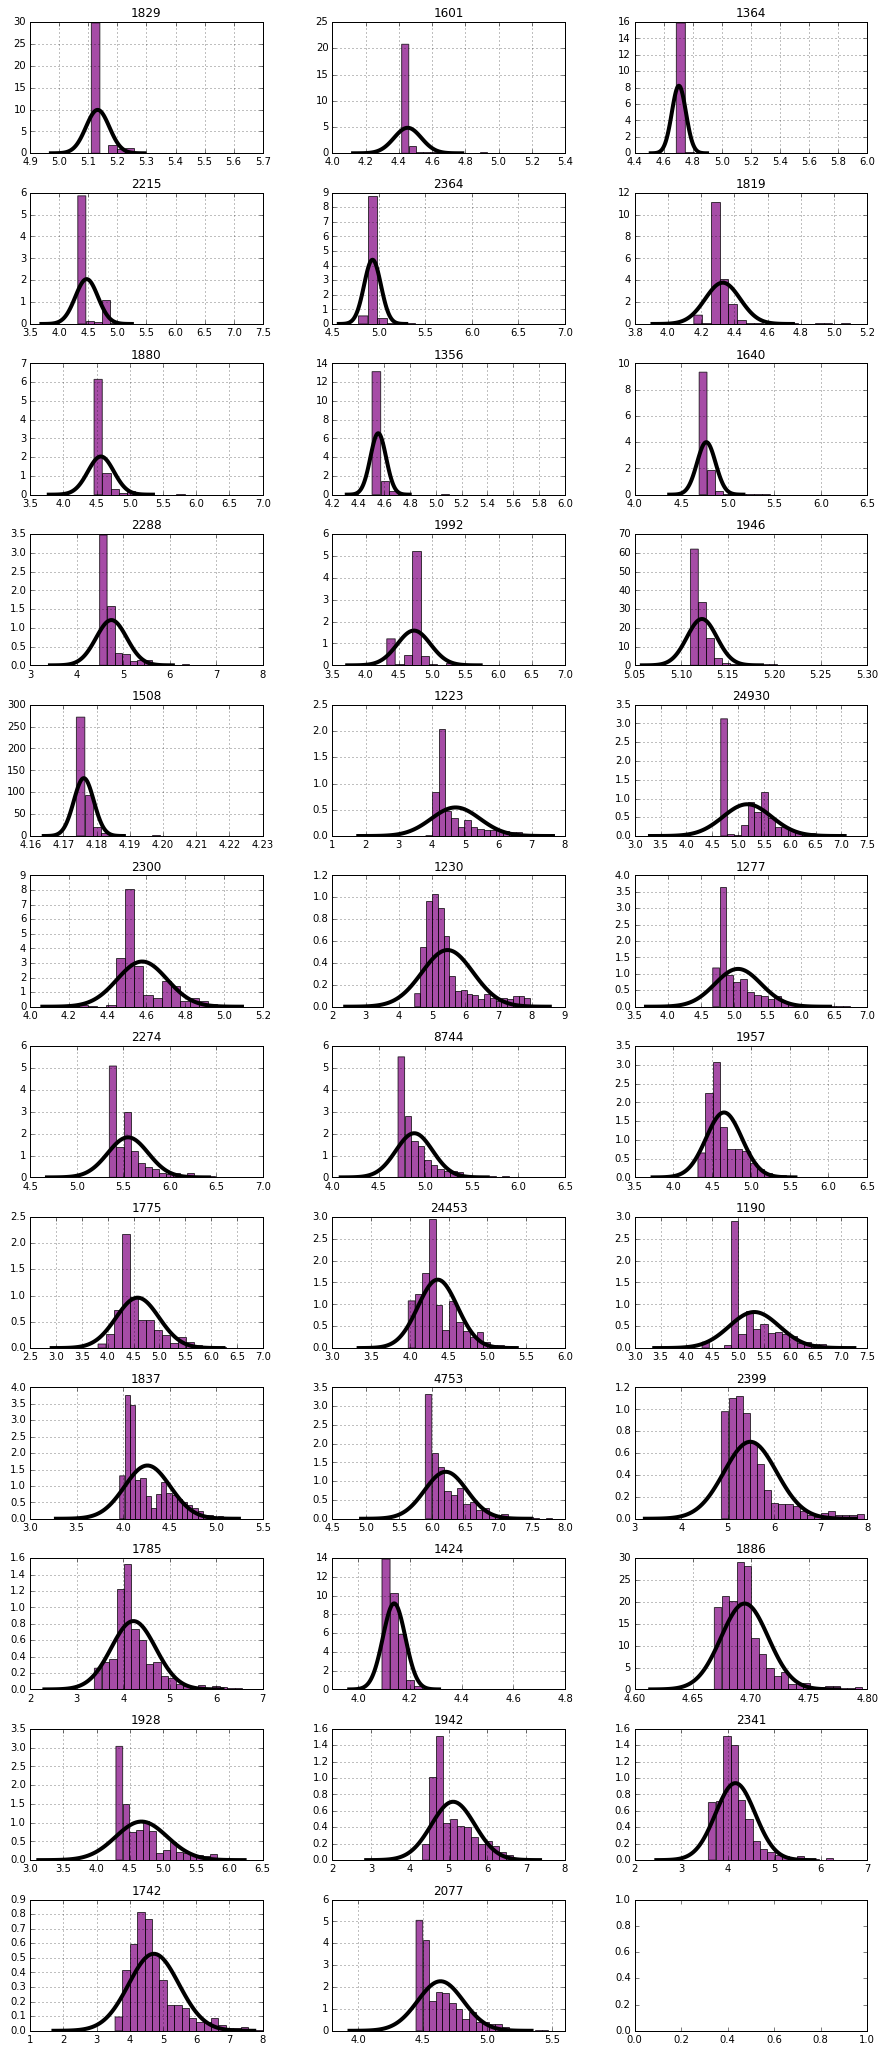

In [215]:
plot_hists(bad['ID'])

0.05


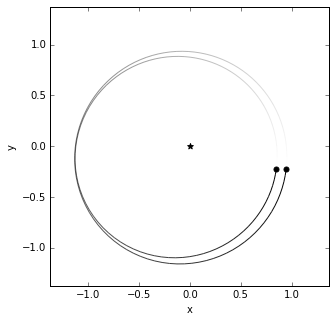

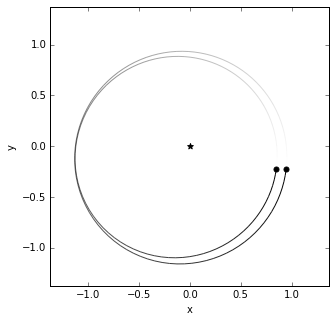

In [291]:
da = 0.05

shift=0.15
theta=np.pi/4
k1 = shift*np.cos(theta)+0.03
h1 = shift*np.sin(theta)
k2 = shift*np.cos(theta)-0.02
h2 = shift*np.sin(theta)

print(np.sqrt((k1-k2)**2 + (h1-h2)**2))
sim = rebound.Simulation()
sim.add(m=.1)
sim.add(a=1., k=k1, h=h1)
sim.add(a=1+da, k=k2, h=h2)
rebound.OrbitPlot(sim)

In [293]:
ps = sim.particles
de = np.sqrt((ps[2].e*np.cos(ps[2].pomega)-ps[1].e*np.cos(ps[1].pomega))**2 + (ps[2].e*np.sin(ps[2].pomega)-ps[1].e*np.sin(ps[1].pomega))**2)
de

0.050000000000001224

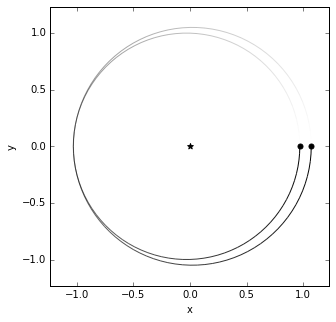

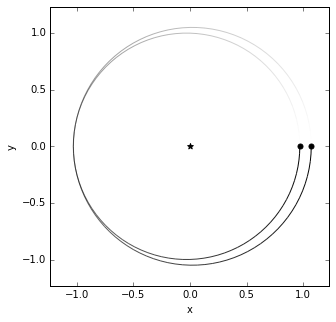

In [288]:
sim = rebound.Simulation()
sim.add(m=.1)
sim.add(a=1., k=0.03)
sim.add(a=1+da, k=-0.02)
rebound.OrbitPlot(sim)

In [216]:
df.head()

,ID,Probability,Mean,Sigma,Mean_Error,Sigma_Error,Determinant,Gamma,Location,Alpha,EV,maxstddetrended,KSpval
0,1007,0.130767,5.584131,0.461519,0.014201,0.010451,2.201230e-08,2.614027,4.447527,1.283371,5.587615,0.002307,9.386954e-02
1,1021,0.185651,6.008010,0.330157,0.010570,0.007475,6.242409e-09,3.269655,4.989150,1.129664,6.002008,0.002665,3.072049e-01
2,1025,0.154975,5.797448,0.387122,0.012399,0.008591,1.134396e-08,2.249906,4.965337,0.938566,5.796653,0.001989,2.789818e-02
3,1041,0.123930,5.732675,0.489208,0.015449,0.010785,2.773702e-08,1.856930,4.863439,0.972277,5.726901,0.001031,8.813668e-07
4,10518,0.143696,6.469809,0.431217,0.013868,0.009608,1.775222e-08,1.596694,5.781111,0.761953,6.464390,0.000726,4.772941e-03


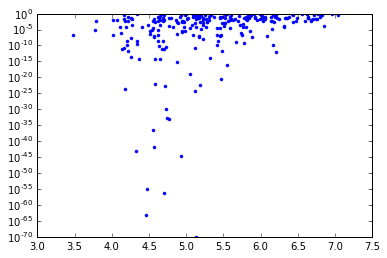

In [219]:
fig, ax = plt.subplots()
ax.plot(df['Mean'], df['KSpval'], '.')
ax.set_yscale('log')

In [48]:
dfshort = pd.read_csv('../../csvs/short_integration_features.csv', index_col=0)


In [49]:
dfshort.head()

,runstring,Stable,instability_time,Rel_Eerr,t_final_short,Rel_Eerr_short,avg_a1,std_a1,max_a1,min_a1,...,avg_iH3,std_iH3,max_iH3,min_iH3,avg_ecross3,std_ecross3,max_ecross3,min_ecross3,norm_a3_slope,Lyapunov_time
0,0000000.bin,0.0,1.235644e+07,1.099985e-04,10000.0,1.346025e-08,1.000165,0.000329,1.001248,0.999691,...,4.706365,0.263380,5.264568,4.410404,0.297364,0.016641,0.339655,0.010871,2.681898e-11,9041.175397
1,0000001.bin,0.0,1.348749e+05,1.388587e-08,10000.0,8.934681e-10,0.999952,0.000739,1.002089,0.998309,...,1.777638,0.610370,2.507803,0.588028,0.115674,0.039718,0.251880,0.137917,-9.314702e-11,2192.382019
2,0000002.bin,0.0,1.276381e+04,3.048261e-04,10000.0,3.169983e-08,0.998498,0.001948,1.002043,0.995446,...,0.982187,0.060058,1.060480,0.875622,0.038930,0.002380,0.026117,0.007227,-4.095504e-11,2191.525922
3,0000003.bin,1.0,1.000000e+09,6.492574e-10,10000.0,6.097589e-10,1.000006,0.000026,1.000126,0.999973,...,9.848375,0.070031,9.914136,9.650551,0.514386,0.003658,0.301072,0.279903,-7.257099e-12,58599.215966
4,0000004.bin,0.0,8.791888e+01,9.336734e-07,10000.0,5.951220e-03,1.067267,0.030186,1.121364,1.000000,...,1.453843,0.726529,2.660701,0.154157,0.496372,0.248052,1.358604,0.261358,-2.610208e-08,43524.152375


In [58]:
dfshort['std_a1']

0        3.291624e-04
1        7.386073e-04
2        1.948476e-03
3        2.551305e-05
4        3.018637e-02
5        3.107891e-04
6        8.010767e-03
7        1.719776e-02
8        1.550797e-04
9        7.195505e-06
10       9.505487e-05
11       4.473053e-05
12       2.581624e-02
13       2.304277e-05
14       1.898118e-05
15       2.282196e-04
16       2.823215e-05
17       5.887980e-04
18       2.633886e-04
19       3.100424e-02
20       4.578556e-05
21       9.523339e-04
22       9.845635e-08
23       8.020749e-02
24       1.721454e-05
25       1.069314e-03
26       1.600532e-05
27       2.331518e-02
28       2.630727e-03
29       7.202585e-03
             ...     
14970    6.365563e-04
14971    6.298050e-04
14972    8.346995e-06
14973    1.028449e-03
14974    2.486807e-03
14975    1.523957e-03
14976    1.318051e-04
14977    5.384510e-05
14978    1.117278e-05
14979    5.202314e-06
14980    1.072515e-04
14981    2.065730e-04
14982    8.038066e-02
14983    6.485951e-07
14984    3

In [61]:
badshort = dfshort.loc[bad]
goodshort = dfshort.loc[good]
goodshort.shape

(213, 118)

In [65]:
goodshort.index

Int64Index([ 1007,  1021,  1025,  1041, 10518,  1052,  1107,  1120,  1124,
             1128,
            ...
             3000,    35,  3898,    42,  5505,  5958,    62,  7431,  8462,
               91],
           dtype='int64', length=213)

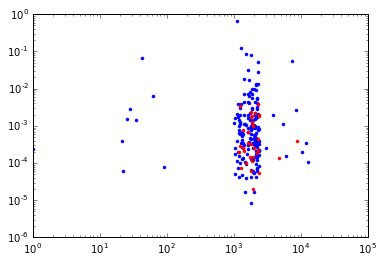

In [89]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(goodshort.index, goodshort['std_a2'], 'b.')
ax.plot(badshort.index, badshort['std_a2'], 'r.')
ax.set_yscale('log')
ax.set_xscale('log')

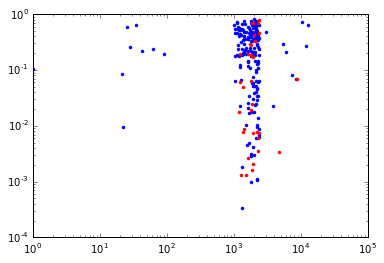

In [88]:
%matplotlib inline
fig, ax = plt.subplots()
ax.plot(goodshort.index, goodshort['norm_std_window10_e2'], 'b.')
ax.plot(badshort.index, badshort['norm_std_window10_e2'], 'r.')
ax.set_yscale('log')
ax.set_xscale('log')

In [86]:
badshort.loc[2364]['std_e2_window']

KeyError: 'std_e2_window'

In [87]:
for i in goodshort.columns:
    print(i)

runstring
Stable
instability_time
Rel_Eerr
t_final_short
Rel_Eerr_short
avg_a1
std_a1
max_a1
min_a1
norm_std_a1
norm_max_a1
norm_std_window10_a1
norm_max_window10_a1
avg_e1
std_e1
max_e1
min_e1
norm_std_e1
norm_max_e1
norm_std_window10_e1
norm_max_window10_e1
avg_inc1
std_inc1
max_inc1
min_inc1
norm_std_inc1
norm_max_inc1
norm_std_window10_inc1
norm_max_window10_inc1
avg_eH1
std_eH1
max_eH1
min_eH1
avg_iH1
std_iH1
max_iH1
min_iH1
avg_ecross1
std_ecross1
max_ecross1
min_ecross1
norm_a1_slope
avg_a2
std_a2
max_a2
min_a2
norm_std_a2
norm_max_a2
norm_std_window10_a2
norm_max_window10_a2
avg_e2
std_e2
max_e2
min_e2
norm_std_e2
norm_max_e2
norm_std_window10_e2
norm_max_window10_e2
avg_inc2
std_inc2
max_inc2
min_inc2
norm_std_inc2
norm_max_inc2
norm_std_window10_inc2
norm_max_window10_inc2
avg_eH2
std_eH2
max_eH2
min_eH2
avg_iH2
std_iH2
max_iH2
min_iH2
avg_ecross2
std_ecross2
max_ecross2
min_ecross2
norm_a2_slope
avg_a3
std_a3
max_a3
min_a3
norm_std_a3
norm_max_a3
norm_std_window10_a3
norm_ma